This code evaluates the differences between various techniques for determining the refractive index and
great-circle distance to regions of ionospheric backscatter using the 2-Parameter Method.
It also allows for estimation of great-circle distance errors when using the Standard and 
Chisham Methods of scatter geolocation. The code is currently designed to compare the
predictions with a single 2-D ray tracing using the code developed by Sebastien de Larquier.
The ray tracing code uses the IRI model to provide a realistic ionosphere for the date,
time, radar, radar operating frequency and beam direction selected. These values are entered in Cell 2. 
Be sure to have stime set to the same value as etime in Cell 2 as this code and its associated plotting
code are only designed to compare the results of a single ray tracing. The analysis can be repeated for 
as many different sets of conditions as you wish. 

Note that the elevation angles nominally extend from 8 to 40 degrees in 0.1 degree increments.
This elevation angle range can be changed by altering the first or second parameter in parentheses in Cell 2.
Normally this elevation angle range suffices, but if you select the wrong operating frequecy for the time of
of day, all of the rays that are being analyzed can be reflected by the ionosphere. Normally, it is best to try and have some of the analyzed rays penetrate the ionosphere and some be reflected.

We believe that this code is an excellent training tool. It enables a researcher to see the type of propagation that a specific radar will encounter when operated at a specific time and frequency. The actual propagation on any given day will differ somewhat from the propagation predicted by the IRI model, but, nevertheless, prediction and reality will display some similarities. This software determines the consistancy that exists between ray-tracing analyses of the great circle distance to ionospheric scattering volumes and the great circle distance predicted by the SuperDARN Standard Method, the SuperDARN Chisham Method and a new 2-Parameter Method. The Standard Method uses the group range to the scattering volume and an assumption of the virtual height, e.g. 350 km, to estimate the great-circle distance. The Chisham method uses a range-dependent virtual height that is derived from averaging 5-years of elevation angle data derived from the SuperDARN interferometery technique and the group range for its determinations of the great circle distance. The 2-Parameter Method is new and requires determinations of both the group range and the initial (or final) elevation angle of the ray. In this program, the elevation angles are known to an accuracy of 0.1 degrees.The ray-tracing algoritm tracks the refracted path of the ray as it propagates through the atmosphere and ionosphere.The three geolocation methods all use similar equations and assume a virtual ray that has a specific virtual height or initial elevation angle. The solution is base on the general solution of an obtuse triangle superposed on a spherical Earth. The obtuse angle is located at the radar site and is equal to 90 degrees plus the elevation angle of the ray. One of the acute angles is located at the center of the Earth and the other is in the ionosphere at the assumed or derived virtual height. In this virtual model, all of the refraction is assumed to take place at the vertex in the ionosphere. If there is agreement between the ray tracing analysis and the geolocation method, a line drawn from the center of the Earth to the vertex in the ionosphere will pass through the actual scattering volume identified from ray tracing.

The 2-Parameter Method exceeds the capabilities of the other two methods by also determining the refractive index of the scattering volume in the ionosphere. This is achieved through Snell's law which is used to determine the amount of refraction required at the virtual height to rotate the ray orthogonally to the magnetic field. The code does this in a general sense using the IGRF magnetic field model and knowing the bearing of the ray and the geographic location on the Earth where the 2-Parameter Method predicts the scatter to occur. For this analysis, the backscatter is assumed to occur at an altitude of 350 km. The accuracy of these estimates is validated through comparison with the refractive indices determined from the ray tracing analysis. These are directly calculated from knowedge of the radar operating frequency and the IRI electron density in the scattering volume.

Good Luck and have fun. This code was developed by Ray Greenwald and Nathaniel Frissell, April 10, 2015

Notes:

At the moment, the code is only valid for northern-hemisphere radars and for 1/2 hop backscatter



In [1]:
%pylab inline
import datetime as dt
from davitpy.models import raydarn
import davitpy
import pandas
import numpy as np
import os

Re = davitpy.utils.Re

Populating the interactive namespace from numpy and matplotlib


In [2]:
sTime = dt.datetime(2012, 9, 20, 18, 0)
eTime = sTime
UTstart = sTime.hour + sTime.minute/60.
UTend = eTime.hour + eTime.minute/60.
radar = 'sas'
beam = 5
freq = 13
elev = (9, 45, 0.1)


In [3]:
# Run the ray tracing for the specified period, radar, beam and frequency
# Use 4 threads (MPI) and output everything to /tmp

try:
    os.remove('/tmp/iscat.0.dat')
except:
    pass
try:
    os.remove('/tmp/gscat.0.dat')
except:
    pass

rto = raydarn.RtRun(sTime, eTime, 
    rCode=radar, beam=beam, freq=freq, 
    outDir='/tmp', nprocs=2,elev=elev)

In [4]:
# Read rays into memory
rto.readRays()

In [5]:
#rto.rays.paths[dt.datetime(2012, 9, 20, 7, 0)]

In [6]:
#rto.elev

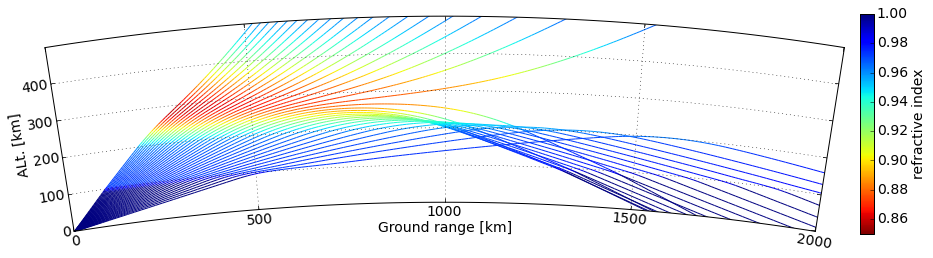

In [7]:
# Plot rays with refractive index color scale
# Plot 1 ray in 10 (1deg increment)
# Plot at start time
figure(figsize=(15,5))
rcParams.update({'font.size': 14})

ax, aax, cbax = rto.rays.plot(sTime, step=10, showrefract=True, nr_lim=[.85,1])

ax.grid()

In [8]:
# Read electron densities into memory
rto.readEdens()

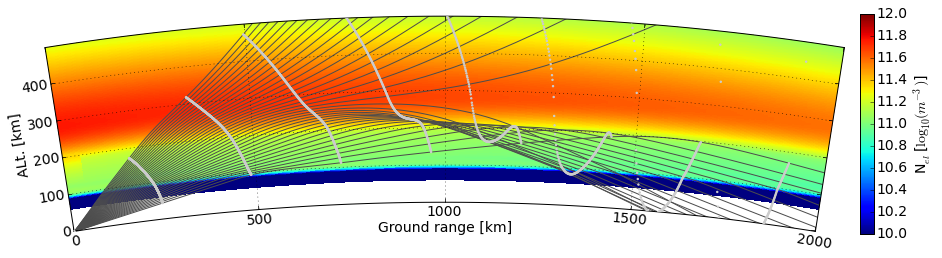

In [9]:
# Plot rays and electron densities together
# Plot at start time
# Plot range markers (every 250 km)
figure(figsize=(15,5))
rcParams.update({'font.size': 14})

ax, aax, cbax = rto.ionos.plot(sTime)
ax, aax, cbax = rto.rays.plot(sTime, 
    step=10, ax=ax, aax=aax)
rto.rays.showRange()

ax.grid()

In [10]:
# Read ionospheric and ground scatter into memory
rto.readScatter()

In [11]:
# rto.rays.writeToAscii('/home/davitpy/Desktop/rays.txt')

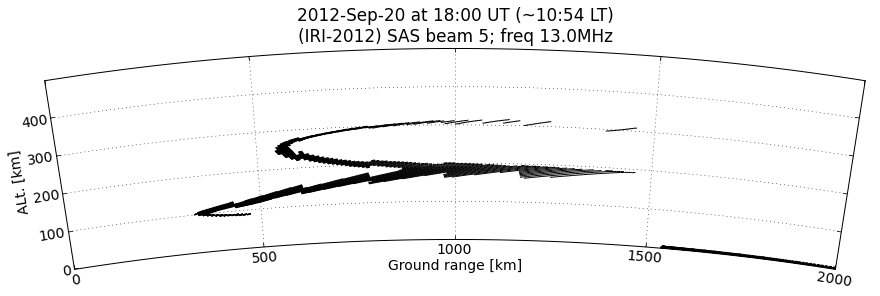

In [12]:
# Plot ionospheric and ground scatter together
# Plot at start time
# Plot relative strength of ionospheric scatter
figure(figsize=(15,5))
rcParams.update({'font.size': 14})

ax, aax, cax = rto.scatter.plot(sTime, title=True, weighted=False)

ax.grid()

In [13]:
#rto.scatter.isc

In [14]:
kt = rto.scatter.isc.keys()[0]
kb = rto.scatter.isc[kt].keys()[0]


In [15]:
dict_list = []
for kt in rto.scatter.isc.keys():
    for kb in rto.scatter.isc[kt].keys():
        elv_dict = rto.scatter.isc[kt][kb]
        for key,value in elv_dict.items():
            for ii in range(value['nstp']):
                tmp_dict = {'time':kt,'beam':kb,'elv_init':key,'radar':radar}
                for param,param_val in value.items():
                    if param == 'nstp': continue
                    tmp_dict[param] = param_val[ii]
                dict_list.append(tmp_dict)

In [16]:
df = pandas.DataFrame(dict_list)

In [17]:
#This code creates an additional dictionary list and DataFrame that identifies the elevation
#angles of all rays that are reflected by the ionosphere and backscattered by the ground.
#Knowledge of the highest elevation angle ground-backscattered ray greatly simplifies the 
#estimation of the refractive indices and great-circle distances to the scatter volumes.
#Currently the DataFrame does not include the great circle distance of the ground scatter.
#This will be an important addition and should be relatively easy to do, especially if the
# code is extended to estimate 1 1/2 hop scatter modes.

dict_list_gs = []
for kt in rto.scatter.gsc.keys():
    for kb in rto.scatter.gsc[kt].keys():
        elv_dict_gs = rto.scatter.gsc[kt][kb]
        for key,value in elv_dict_gs.items():
            tmp_dict_gs = {'time':kt, 'beam':kb, 'elv_init':key, 'radar':radar}
            dict_list_gs.append(tmp_dict_gs)
                             

In [18]:
dgs = pandas.DataFrame(dict_list_gs)

In [19]:
dgs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 163 entries, 0 to 162
Data columns (total 4 columns):
beam        163 non-null int64
elv_init    163 non-null float64
radar       163 non-null object
time        163 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.4+ KB


In [20]:
dgs['elv_init']

0       9.5
1      10.5
2      22.6
3      24.3
4      11.1
5      11.5
6      10.0
7      11.0
8      12.0
9      13.0
10     14.0
11     15.0
12     16.0
13     17.0
14     18.0
15     19.0
16     17.4
17     21.0
18     22.0
19     23.0
20     24.0
21     25.0
22     19.5
23     22.8
24     21.8
25     12.2
26     18.2
27     19.9
28     22.5
29      9.4
       ... 
133    13.2
134    11.3
135    20.8
136    18.1
137    19.8
138    15.2
139    20.5
140    11.9
141    17.9
142    11.6
143    25.4
144    11.2
145    12.4
146    18.6
147    12.3
148    10.4
149    14.6
150    10.3
151    24.7
152    18.4
153    15.8
154    19.1
155    12.5
156    17.5
157    15.7
158    11.7
159    25.2
160    18.9
161    10.1
162    19.6
Name: elv_init, dtype: float64

In [21]:
size_gs = dgs.size
print size_gs

652


In [22]:
#The two-parameter analysis runs from the highest elevation-angle ray that detects scatter to the
#lowest. To accomplish this, both the df and dgs DataFrames need to be re-sorted and reindexed to run
#from high to low elevation angles. The re-sorted rays can be slassified into three groups.
#Group 1:Rays that refract sufficiently to be backscattered and then quickly penetrate the ionosphere.
#Group 2: Rays that backscatter below the peak of the F-region and again above the peak of the F-layer
#after which they penetrate the ionosphere. Group 3: Rays that backscatter below the peak of the F-layer
#and then are reflected by the ionosphere. Each group is processed by its associated phase of the
#analysis.

if size_gs != 0:
    dgs.sort('elv_init', ascending=False, inplace=True)

In [23]:
if size_gs != 0:
    dgs.reset_index(drop=True, inplace=True)

In [24]:
if size_gs != 0:
    dgs.head(64)

In [25]:
del df['w']

In [26]:
#The peak electron density of the F-region ionosphere undergoes significant variation 
#in the course of a day. This variation requires a minimum of two operating 
#frequencies: one for daytime operation and one for nighttime operation. A third
#intermediate frequency might also be desirable for the dawn and dusk transitions. One
#can assure similar propagagion conditions, if the ground scatter footprint of a 
# signal at a specific initial elevation angle remains at  a similiar great circle
#distance. The equations below are used to identify the local time of the UT time that
#is being processed. The minimum ionospheric electron density occurs 1-2 hours before 
#local dawn, while the maximum density occurs a few hours afer local noon.

hysteresis = 2.
df['Loc_time'] = (df['time'][0].hour + df['time'][0].minute/60. + df['lon']/15. - hysteresis) % 24.

In [27]:
#df.describe()

In [28]:
df['lgc_rt']=df['th'] * Re

In [29]:
#df.info()

In [30]:
#df.head(64)

In [31]:
df['height']=df['r']/1000.-Re

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2487 entries, 0 to 2486
Data columns (total 15 columns):
beam        2487 non-null int64
elv_init    2487 non-null float64
gran        2487 non-null float64
h           2487 non-null float64
lat         2487 non-null float64
lon         2487 non-null float64
nr          2487 non-null float64
r           2487 non-null float64
radar       2487 non-null object
rel         2487 non-null float64
th          2487 non-null float64
time        2487 non-null datetime64[ns]
Loc_time    2487 non-null float64
lgc_rt      2487 non-null float64
height      2487 non-null float64
dtypes: datetime64[ns](1), float64(12), int64(1), object(1)
memory usage: 310.9+ KB


In [33]:
df['h_2p'] = np.sqrt(Re**2 + (df['gran']*1e-3)**2 + 2*(df['gran']*1e-3)*Re*np.sin(df['elv_init']*np.pi/180.)) - Re
df['h_2p'].describe()

count    2487.000000
mean      261.055112
std       110.548579
min        89.129757
25%       183.852701
50%       265.450691
75%       304.168498
max       892.656876
Name: h_2p, dtype: float64

In [34]:
#The minimum height of the peak of the F-region electron density profile occurs a few hours
#after local noon and the minimum height occurs a few hours before dawn. EUV photons emitted
#by the sun is the principal process for creation of the ionosphere and 3-body recombination
#is the principal process for its decay. THe third body in the reaction is a neutral atom. Since
#the neutral density of the upper atmosphere decreases with altitude, the ionosphere after sunset
#decays from the bottom up. This equation is used in the 2-parameter analysis to mirror the
#in height of the ionosphere over a day. The changes in virtual height affect the Earth-centered
#included by the group path and the initial elevation angle and ultimately impact the great-circle
#distance of the scattering volume. The expression below optimmizes the diurnal variation of the
#virtual height and great-circle distance.

tmp = []
for index,row in df.iterrows():
    h_2p_max = 500. + 50*np.cos(row['Loc_time']*np.pi/12.) 
    if row['h_2p'] > h_2p_max:
        row['h_2p'] = h_2p_max
    tmp.append(row)    
df = pandas.DataFrame(tmp)
del tmp
df['h_2p'].describe()


count    2487.000000
mean      255.298096
std        92.656240
min        89.129757
25%       183.852701
50%       265.450691
75%       304.168498
max       463.671592
Name: h_2p, dtype: float64

In [35]:
df['th_2p']  = np.arcsin((df['gran']*1e-3)*np.cos(df['elv_init']*np.pi/180.) / (Re + df['h_2p']))
df['lgc_2p'] = df['th_2p'] * Re 

In [36]:
df['nr_2p'] = np.zeros_like(df['th_2p'], dtype=np.float)
size = df['th_2p'].size
df['phase'] = np.zeros_like(df['beam'], dtype = np.int64)

In [37]:
#Calculate 2p lat/lon for each step.
df['lat_2p'], df['lon_2p'] = davitpy.utils.greatCircleMove(rto.site.geolat, rto.site.geolon, df['lgc_2p'], rto.azim[0])

#Calculate bearing of each step
lats_lons = zip(np.array(df['lat_2p']), np.array(df['lon_2p']))
bearing = []
for lat, lon in lats_lons:
    bearing.append((davitpy.utils.greatCircleAzm(lat,lon,rto.site.geolat,rto.site.geolon) + 180.) % 360.)

df['bearing'] = bearing

In [38]:
# INPUTS
itype = 2 # 1 for Geodetic coordinates (Spheroid) OR 2 for Geocentric (Sphere)
decimal_yr = davitpy.utils.dateToDecYear(sTime) # decimal year
igrf_alt = 350. + Re # altitude
stp = 5.
xlti, xltf, xltd = -90.,90.,stp # latitude start, stop, step
xlni, xlnf, xlnd = -180.,180.,stp # longitude start, stop, step
ifl = 0 # Main field
# Call fortran subroutine
#lat,lon,d,s,h,x,y,z,f = davitpy.models.igrf.igrf11(itype,decimal_yr,igrf_alt,ifl,xlti,xltf,xltd,xlni,xlnf,xlnd)

lats_lons = zip(np.array(df['lat_2p']), np.array(df['lon_2p']))
mag_field = []
for lat, lon in lats_lons:
    #if lat > 0:
    result =  davitpy.models.igrf.igrf11syn(0,decimal_yr,itype,igrf_alt,90.-lat,lon)
    mag_field.append(result)
    #else:
        #result =  davitpy.models.igrf.igrf11syn(0,decimal_yr,itype,igrf_alt,-90.-lat,lon)
        #mag_field.append(result)
df['bx'], df['by'], df['bz'], df['B'] = zip(*mag_field)

# "b_along_ray_path"
df['b_kx'] = np.cos(np.radians(df['bearing']))*df['bx'] + np.sin(np.radians(df['bearing']))*df['by']

#for b_comp in ['bx','by','bz','b_kx']:
#    df[b_comp] = df[b_comp]/df['B']
df['b_kx'] = df['b_kx']/df['B']
df['b_kz'] = df['bz']/df['B']
df['dip'] = np.degrees(np.arctan2(df['b_kz'],df['b_kx']))

#df['beta'] = 90. - np.degrees(df['th_2p']) - df['elv_init']
#df['rot'] = df['dip'] - df['beta']

In [39]:
mag_list = ['gran', 'lgc_2p','elv_init','nr','b_kx','b_kz','dip']

df[mag_list]


,gran,lgc_2p,elv_init,nr,b_kx,b_kz,dip
0,455000,442.817461,9.5,0.994785,0.201446,0.979145,78.374361
1,465000,452.401918,9.5,0.991290,0.200471,0.979342,78.431374
2,1215000,1149.143013,9.5,0.971707,0.133700,0.990387,82.311704
3,1225000,1158.110220,9.5,0.971594,0.132898,0.990490,82.358023
4,1235000,1167.068292,9.5,0.971475,0.132099,0.990593,82.404197
5,1245000,1176.017207,9.5,0.971348,0.131303,0.990694,82.450226
6,1255000,1184.956943,9.5,0.971215,0.130509,0.990795,82.496111
7,1265000,1193.887479,9.5,0.971071,0.129717,0.990894,82.541852
8,1275000,1202.808795,9.5,0.970918,0.128928,0.990993,82.587449
9,1285000,1211.720869,9.5,0.970753,0.128141,0.991090,82.632901


In [40]:
result

(6760.527159643398, 548.026206954954, 49509.47206251989, 49971.92095676554)

In [41]:
df.sort(['elv_init', 'gran'], ascending=[False, True], inplace=True)
print size

2487


In [42]:
df.reset_index(drop=True, inplace=True)

In [43]:
#df.info()

In [44]:
#see = ['elv_init','gran', 'phase','height','h_2p', 'th', 'th_2p']
#df[see].tail(80)

In [45]:
# Determine the "phase" of the analysis.
#   Phase 1: Radar rays that eventually penetrate the ionosphere
#   Phase 2: Radar rays that eventually produce ground scatter.

phase_nr  = np.zeros([len(df)],dtype=np.int)

if size_gs != 0:
    max_elv_init_gs = dgs['elv_init'][0]
    tf = np.array( df['elv_init'] <= max_elv_init_gs )
    phase_nr[tf] = 2
    phase_nr[phase_nr == 0] = 1
else: 
    phase_nr = 1
    max_elv_init_gs = 0.

df['phase'] = phase_nr

print df['elv_init'][0], max_elv_init_gs

28.7 25.4


In [46]:
#df.head(128)

In [47]:
def calc_nr(elv_init,th_2p):
    nr_2p = np.sin((90-elv_init-th_2p*180./np.pi)*np.pi/180.)
    return nr_2p

In [48]:
nr_2p = np.zeros([len(df)],dtype=np.float)
last_elv = df['elv_init'][0]
for index, row in df.iterrows():
    if index == 0 and row['h_2p'] >= 220.:
        nr_2p[index] = calc_nr(row['elv_init'], row['th_2p'])/np.sin(row['dip']*np.pi/180.)
        last_nr_2p = nr_2p[index]*np.sin(row['dip']*np.pi/180.)
        last_elv = row['elv_init']
    elif row['h_2p'] < 220.:
        nr_2p[index] = calc_nr(row['elv_init'], row['th_2p'])/np.sin(row['dip']*np.pi/180.)
        #last_elv = row['elv_init']
    elif row['elv_init'] <  last_elv and row['phase'] == 1:
        nr_2p[index] = calc_nr(row['elv_init'], row['th_2p'])/np.sin(row['dip']*np.pi/180.)
        last_nr_2p = nr_2p[index]*np.sin(row['dip']*np.pi/180.)
        last_elv = row['elv_init']
    elif row['elv_init'] == last_elv and row['phase'] == 1:
        nr_2p[index] = last_nr_2p/np.sin(row['dip']*np.pi/180.)
    elif row['phase'] == 2:
        nr_2p[index] = calc_nr(row['elv_init'], row['th_2p'])/np.sin(row['dip']*np.pi/180)
    
df['nr_2p'] = nr_2p

In [49]:
#nr_offset = df['nr'].mean() - df['nr_2p'].mean()
#print nr_offset
#df['nr_2p'] = df['nr_2p'] + nr_offset

In [50]:
lgc_offset = df['lgc_rt'].mean() - df['lgc_2p'].mean()
print lgc_offset
df['lgc_2p'] = df['lgc_2p'] + lgc_offset

5.50492050265


In [51]:
see = ['elv_init','gran', 'phase', 'th','th_2p', 'nr','nr_2p', 'height', 'h_2p', 'dip']
df[see].tail(-400)

,elv_init,gran,phase,th,th_2p,nr,nr_2p,height,h_2p,dip
400,25.3,645000,2,0.087953,0.087509,0.894030,0.879280,242.3465,301.176936,79.050577
401,25.3,655000,2,0.089275,0.088802,0.891968,0.878472,244.8260,306.229890,79.098616
402,25.3,665000,2,0.090596,0.090093,0.890096,0.877666,247.8095,311.293988,79.146512
403,25.2,635000,2,0.086711,0.086298,0.897098,0.880930,240.0670,295.177213,79.005508
404,25.2,645000,2,0.088035,0.087594,0.894813,0.880123,241.7435,300.204646,79.053739
405,25.2,655000,2,0.089358,0.088889,0.892728,0.879316,244.2185,305.243272,79.101827
406,25.1,635000,2,0.086790,0.086382,0.897878,0.881770,239.5270,294.218349,79.008612
407,25.1,645000,2,0.088115,0.087679,0.895569,0.880964,241.1615,299.231415,79.056892
408,25.1,655000,2,0.089439,0.088975,0.893460,0.880158,243.6060,304.255697,79.105029
409,25.1,665000,2,0.090763,0.090269,0.891542,0.879353,246.5975,309.291170,79.153023


In [52]:
#df['th_2p'].describe()

In [53]:
#df['lgc_rt'].describe()

In [54]:
#df['lgc_2p'].describe()

In [55]:
#df['nr_2p'].describe()

In [56]:
#df['nr'].describe()

In [57]:
#CODE TO DETERMINE GREAT-CIRCLE DISTANCES FOR STANDARD METHOD

hv_sm = np.zeros([len(df)],dtype=np.float)
hve = 115.
hvf = 350.
for index, row in df.iterrows():
    gran_km = row['gran']/1000.
    if gran_km < 600.:
        hv_sm[index] = hve
    elif 800. > gran_km >= 600.:
        hv_sm[index] = (gran_km-600.)*(hvf-hve)/200. + hve
    else:
        hv_sm[index] = hvf
df['hv_sm'] = hv_sm
df['th_sm'] = np.arccos((Re**2.+(Re+ df['hv_sm'])**2-(df['gran']*1e-3)**2)/(2.*Re*(Re+ df['hv_sm'])))
df['lgc_sm'] = df['th_sm'] * Re

In [58]:
#CODE TO DETERMINE GREAT-CIRCLE DISTANCES FOR CHISHAM METHOD

hv_cm = np.zeros([len(df)],dtype=np.float)
for index1, row in df.iterrows():
    gran_km1 = row['gran']/1000.
    if gran_km1 < 790.:
        hv_cm[index1] = 108.974 + 0.0191721*gran_km1 + 6.6828*1e-5*gran_km1*gran_km1
    else:
        hv_cm[index1] = 384.416 - 0.17864*gran_km1 + 1.81405*1e-4*gran_km1*gran_km1
        
df['hv_cm'] = hv_cm       
df['th_cm'] = np.arccos((Re**2.+(Re+ df['hv_cm'])**2-(df['gran']*1e-3)**2)/(2.*Re*(Re+ df['hv_cm'])))
df['lgc_cm'] = df['th_cm'] * Re

In [59]:
#df.info()

In [60]:
#CODE FOR DETERMINING LGC AND NR DIFFERENCES BETWEEN RAY TRACING AND 2P-METHOD
#DIFFERENCES IN LGC BETWEEN RAY TRACING AND STANDARD/CHSHAM METHODS ARE COMMENTED OUT

df['lgc_diff_2p'] = df['lgc_rt'] - df['lgc_2p']
df['lgc_diff_sm'] = df['lgc_rt'] - df['lgc_sm']
df['lgc_diff_cm'] = df['lgc_rt'] - df['lgc_cm']
df['nr_diff_2p'] = df['nr'] - df['nr_2p'] 

In [61]:
#df.head(700)
#THE COMPLETED DF DATAFRAME BELOW SHOWS IN THE 5 RIGHT-HAND COLUMNS: LGC AND NR FROM THE 2P-ANALYSIS,
#THE PHASE OF THE ANALYSIS, AND THE DIFFERENCE IN RAY-TRACING AND 2-P DETERMINATIONS OF LGC AND NR. 


In [62]:
#df.info()

(180, 1980)

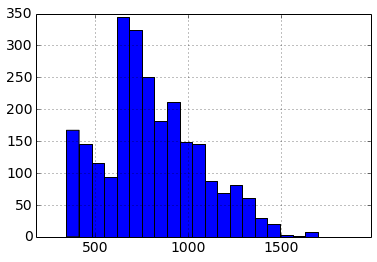

In [63]:
(df['gran']/1000).hist(bins=20)
plt.xlim(180, 1980)


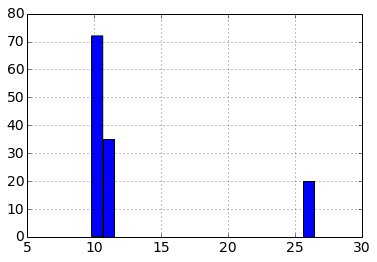

In [64]:
elv_init_select = np.zeros([len(df)],dtype=np.float)
for index1, row in df.iterrows():
    gran_km1 = row['gran']/1000.
    if gran_km1 > 1080 and gran_km1 < 1170:
        elv_init_select[index1] = df['elv_init'][index1]
    else:
        elv_init_select[index1] = nan
df['elv_init_select'] = elv_init_select
df['elv_init_select'].hist(bins=20)

(-200, 200)

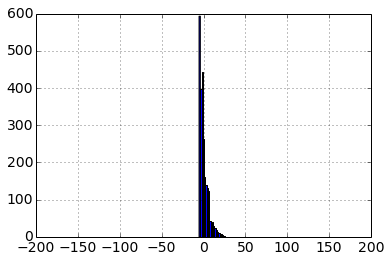

In [65]:
df['lgc_diff_2p'].hist(bins=20)
plt.xlim(-200, 200)


In [66]:
df['lgc_diff_2p'].describe()

count    2.487000e+03
mean    -5.284358e-14
std      5.275211e+00
min     -5.437671e+00
25%     -3.706344e+00
50%     -1.727117e+00
75%      2.297770e+00
max      2.513424e+01
Name: lgc_diff_2p, dtype: float64

In [67]:
df['lgc_diff_sm'].describe()

count    2487.000000
mean        4.472418
std        39.485026
min      -173.511261
25%       -13.055136
50%         6.968955
75%        37.037435
max        63.217921
Name: lgc_diff_sm, dtype: float64

(-300, 200)

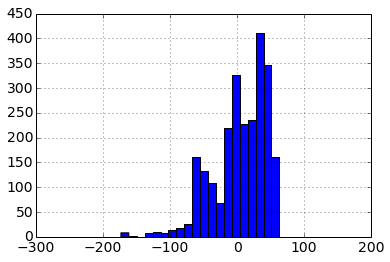

In [68]:
df['lgc_diff_sm'].hist(bins=20)
plt.xlim(-300, 200)

In [69]:
#df['h_2p'].describe()

(-300, 200)

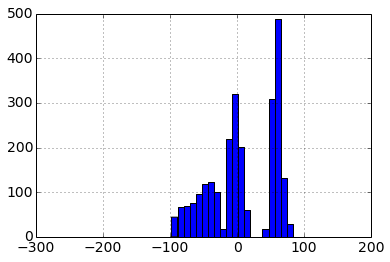

In [70]:
df['lgc_diff_cm'].hist(bins=20)
plt.xlim(-300, 200)

In [71]:
df['lgc_diff_cm'].describe()

count    2487.000000
mean        6.731880
std        48.381302
min       -98.022971
25%       -32.475045
50%         1.425033
75%        56.534176
max        83.161162
Name: lgc_diff_cm, dtype: float64

(-0.2, 0.2)

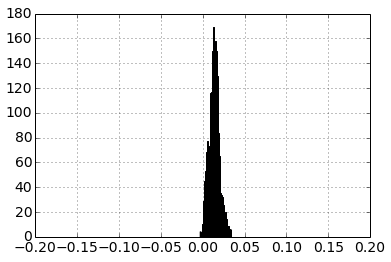

In [72]:
df['nr_diff_2p'].hist(bins=40)
plt.xlim(-0.2, 0.2)

In [73]:
df['nr_diff_2p'].describe()

count    2487.000000
mean        0.013356
std         0.006434
min        -0.002931
25%         0.009366
50%         0.013416
75%         0.017182
max         0.034251
Name: nr_diff_2p, dtype: float64

In [74]:
home_dir = os.getenv('HOME')
df.to_csv(os.path.join(home_dir,'Desktop/data.csv'))

In [75]:
#df['nr_2p'].describe()